**Getting Beaudoin data for making models**

(1) Set up the packages & (2) Connect to Google Drive 

In [ ]:
%%capture  
!apt install gdal-bin python-gdal python3-gdal 
%pip install pandas fiona shapely pyproj
!apt install python3-rtree 
!pip install geopandas==0.10.0
!pip install descartes
!pip install scipy 
!pip install statsmodels
!pip install matplotlib
!pip install gdal
!pip install numpy
!pip install scikit-learn
!pip install statsmodels

In [ ]:
#Here we are importing the packages we need. 
import geopandas as gpd
import pandas as pd 
from geopandas.tools import sjoin
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import shape
from descartes import PolygonPatch
import time
import math
import scipy.stats as stats
import numpy as np
import os, sys
from pyproj import CRS, Transformer
import fiona

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib as mpl
from math import floor

from shapely.ops import unary_union

import warnings
warnings.filterwarnings('ignore')

from osgeo import ogr, gdal,osr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Connect to google drive to get the data. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Navigate to folder where data is stored in the drive. 
%cd /content/drive/MyDrive/jameslab/

dirname = '/content/drive/MyDrive/jameslab/'

/content/drive/MyDrive/jameslab


(3) Here is how to access & display the Beaudoin data and export it as a dataframe into a comma-delimited txt file. 

In [ ]:
def get_val_in_fire(fire_shapefile, shapefile,interpolated_surface,transform,\
                    size,srcds,factor, show = False):
    '''This is a function to get the value inside the fire.
    We will use to calculate the mean, median, max value for a fire.
    
    Parameters
    ----------
        fire_shapefile : string
            path to the fire shapefile 
        shapefile : string
            path to the study area shapefile
        interpolated_surface : ndarray
            an array of values in the study area
        transform : list 
            list describing GeoTransform of raster 
        size : list 
            pixel dimensions
        srcds : GDAL object
            read in raster
        factor : int
            factor by which to multiply number of points in each pixel 
            higher = more accurate 
        show : bool 
            whether or not to show a map 
            
    Returns
    ----------
        float (3)
            median, mean, max value in fire, by default False
    '''

    # Get the bounding box of the fire shapefile
    bounds = gpd.GeoDataFrame(geometry=[fire_shapefile['geometry']]).bounds 
    xmax = np.nanmax(bounds['maxx'])
    xmin = np.nanmin(bounds['minx'])
    ymax = np.nanmax(bounds['maxy'])
    ymin = np.nanmin(bounds['miny'])

    #Get information about the raster - what is pixel size? What is the origin?
    xOrigin = transform[0]
    yOrigin = transform[3]
    xMax = xOrigin + transform[1] * size[0]
    yMin = yOrigin + transform[5] * size[1]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    # Calculate the number of rows cols to fill the bounding box at that resolution
    num_col = int((xmax - xmin) / pixelHeight)+1
    num_row = int((ymax - ymin) / pixelWidth)+1

    yProj_extent = [bounds['maxy'], bounds['miny']]
    xProj_extent = [bounds['maxx'], bounds['minx']]

    # Get evenly spaced points inside the bounds
    Yi = np.linspace(np.min(yProj_extent), np.max(yProj_extent), num_row*factor)
    Xi = np.linspace(np.min(xProj_extent), np.max(xProj_extent), num_col*factor)

    Xi, Yi = np.meshgrid(Xi, Yi)
    # This puts it into a format where we have individual points in array
    concat = np.array((Xi.flatten(), Yi.flatten())).T
    send_to_list = concat.tolist()

    # Convert each point to shapely Point format
    meshPoints = [Point(item) for item in send_to_list]
    
    # Making a geodataframe with the points 
    gdf = gpd.GeoDataFrame(geometry=meshPoints)

    
    DF = fire_shapefile
    
    try: #If there is a single polygon in the shapefile
        DF = unary_union(Polygon(DF['geometry'])) #Multipolygon --> Polygon
        poly_define = gpd.GeoDataFrame(geometry=[DF])
        # Get points falling in fire 
        within_fire = gdf[gdf.geometry.within(poly_define['geometry'][0])]
    # Catch the case where multiple polygons not continuous make up the shp
    except (NotImplementedError,AttributeError,TypeError) as e:
        DF = [unary_union(Polygon(geom)) for geom in list(DF['geometry'])]
        poly_define = gpd.GeoDataFrame(geometry=DF)
        # Left spatial join 
        within_fire = sjoin(gdf, poly_define, how='left',op='within')
        # Drop points that are not in the fire 
        within_fire = within_fire[~np.isnan(within_fire['index_right'])]
        

    inside_fire = []
    lon = []
    lat = [] 
    listP = within_fire
    # Iterate through the points within the fire 
    for idx,p in listP.iterrows():
        #mx , my is the lon lat 
        mx,my=np.array(p['geometry'].coords.xy[0])[0], np.array(p['geometry'].coords.xy[1])[0]
        
        # Calculate offset on the array 
        col = int(np.floor((mx - xOrigin)) / pixelHeight)
        row = int(np.floor((my - yOrigin)) / pixelWidth)
        # Index the array where the point is and send to list to store it 
        inside_fire.append(interpolated_surface[row-1][col])

        lon.append(mx)
        lat.append(my)

    #Add values in list to the within_fire dataframe 
    within_fire['values'] = inside_fire
    within_fire['lon'] = lon
    within_fire['lat'] = lat

    if show: # If True make a figure 

        fig, ax = plt.subplots(figsize=(15, 15))
        gk = plt.imshow(interpolated_surface,extent=(
                xOrigin,xMax,yOrigin,
                yMin),vmin=0,vmax=100,cmap='Greens')
        
        sc = plt.scatter(within_fire['lon'],within_fire['lat'],
                         c=within_fire['values'],cmap='Greens',edgecolors='k',
                         vmin=0,vmax=100,s=10)
        gpd.GeoDataFrame(geometry=
                         [fire_shapefile['geometry']]).plot(ax=ax,
                                                            facecolor='None',
                                                            edgecolor='k')
        c = fig.colorbar(gk)
        c.set_label('% Basal Area Pinus Contorta', rotation=270)
        ax.set_title(fire_shapefile['FIRE_ID'])
        ax.set_ylim([np.min(within_fire['lat'])-2000,
                     np.max(within_fire['lat'])+2000])
        ax.set_yticks([])
        ax.set_xlim([np.min(within_fire['lon'])-2000,
                     np.max(within_fire['lon'])+2000])
        ax.set_xticks([])
        plt.show()

    within_fire = within_fire[within_fire['values'] >= 0]
    

    if len(within_fire) > 0: #If points in fire 

        median_in_fire = np.nanmedian(within_fire['values'])
        mean_in_fire = np.nanmean(within_fire['values'])
        max_in_fire = np.nanmax(within_fire['values'])
    else: # If no points fall in fire 
        median_in_fire = np.nan
        mean_in_fire = np.nan
        max_in_fire = np.nan 


    return median_in_fire, mean_in_fire, max_in_fire # Return median mean max

def decide_beaudoin_raster(year): 
  '''Decide whether to use 2001 or 2011 data
  '''

  if year >= 2006: 
    v = 2011

  else: 
    v = 2001

  return v


In [58]:
def get_species_for_fire(species_latin_name): 
    '''Get species abundance for each fire 
    
    Parameters
    ----------
        species_latin_name : string
            species latin name, one of: 
            Pinus_Contorta
            Pinus_Banksiana
            Pinus_Ponderosa 
            
    Returns
    ----------
        Pandas dataframe
            dataframe with each fire + its information (size, etc.) + 
            a column with species of interest
      
    '''  
    #Specifications from Doriana 
    sa = gpd.read_file('study_area/BC_AB_shapefile.shp')
    shp = gpd.read_file('fire_perimeters/NFDB_poly_20210707_epsg4326.shp')
    shp = shp[shp['SIZE_HA'] >= 10]
    shp_prov = shp[shp['SRC_AGENCY'].isin(['AB','BC'])]
    shp_year = shp_prov[shp_prov['YEAR'] >= 1985]
    shp_year = shp_year[shp_year['YEAR'] <= 2015]
    shp_type = shp_year[shp_year['CAUSE'] == 'L'].to_crs('esri:102001')
    print('Number of fires to process:' +str(len(shp_type)))

    #Make empty lists to store data in
    pinus = [] 
    geometries = [] 
    fire_ids = [] 
    rep_dates = [] 
    size_has = [] 

    count = 1
    #Iterate through fires
    for index, fire in shp_type.iterrows():
        #print(fire['FIRE_ID'])
        #print('This fire is number: '+str(count))

        #Store some important information in the lists 
        fire_ids.append(fire['FIRE_ID'])
        rep_dates.append(fire['REP_DATE'])
        size_has.append(fire['SIZE_HA'])
        geometries.append(fire['geometry'])

        # Decide which Beaudoin data to use, 2001 or 2011
        vyear= decide_beaudoin_raster(fire['YEAR'])
        if vyear == 2011: 
            # Open selected raster using gdal 
            src_ds = gdal.Open('Beaudoin/2011/Beaudoin_'+species_latin_name+
                      '_BC_AB_esri_102001.tif')
            # Get band 1 
            rb1=src_ds.GetRasterBand(1)
            transform=src_ds.GetGeoTransform()
            cols = src_ds.RasterXSize
            rows = src_ds.RasterYSize

            # Convert raster to array 
            data = rb1.ReadAsArray(0, 0, cols, rows)
            if count == 1 or count == 50: #Just print out figure to make sure ok
                med,ave,max=get_val_in_fire(fire,sa,data,transform,
                                            (cols,rows,),src_ds,3,show=True)
            else: 
                 med,ave,max=get_val_in_fire(fire,sa,data,transform,
                                            (cols,rows,),src_ds,3)             
            pinus.append([med,ave,max])
        else: 
            src_ds1 = gdal.Open('Beaudoin/2001/Beaudoin_'+species_latin_name+
                 '_BC_AB_2001_esri_102001.tif')
            rb2=src_ds1.GetRasterBand(1)
            transform=src_ds1.GetGeoTransform()
            cols = src_ds1.RasterXSize
            rows = src_ds1.RasterYSize

        
            data = rb2.ReadAsArray(0, 0, cols, rows)
            if count == 1 or count == 50: 
                med,ave,max =get_val_in_fire(fire,sa,data,transform,
                                            (cols,rows,),src_ds1,3,show=True)
            else: 
                med,ave,max =get_val_in_fire(fire,sa,data,transform,
                                            (cols,rows,),src_ds1,3)  
            # Store median, mean, max vals for fire in list             
            pinus.append([med,ave,max])
        count+=1

    # Create output dataframe 
    outputdf = pd.DataFrame()
    outputdf[species_latin_name+' median'] = [i[0] for i in pinus]
    outputdf[species_latin_name+' mean'] = [i[1] for i in pinus]
    outputdf[species_latin_name+' max'] = [i[2] for i in pinus]
    outputdf['fireid'] = fire_ids
    outputdf['report_date'] = rep_dates
    outputdf['size_ha'] = size_has 
    outputdf['geometry'] = geometries 

    #Print part of table to make sure everything ok
    print(outputdf.head(20))
    return outputdf

(3) Get pinus contorta Beaudoin data

Number of fires to process:2402


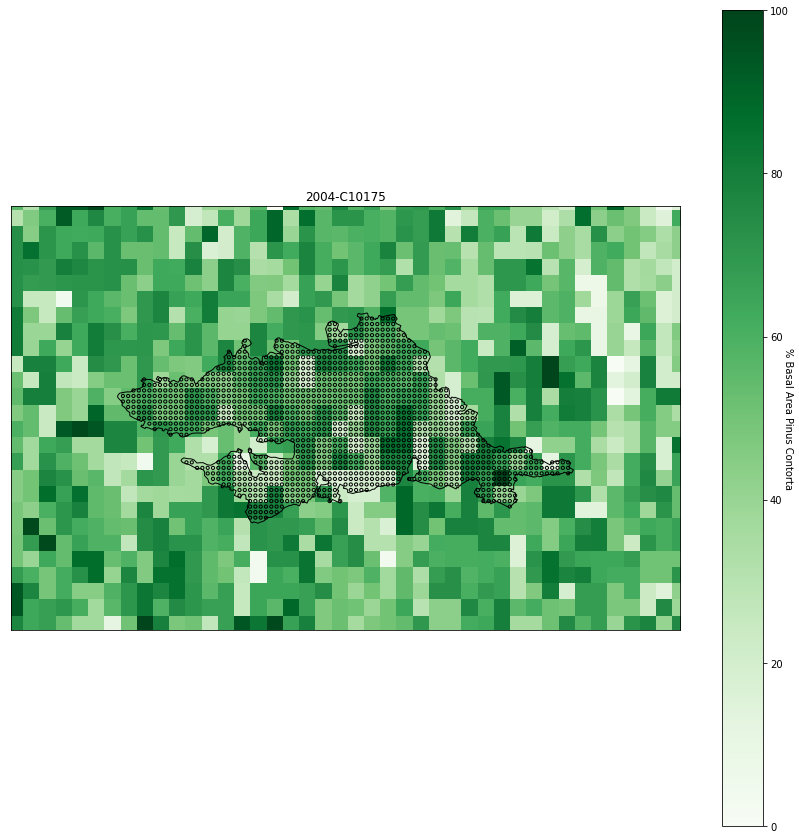

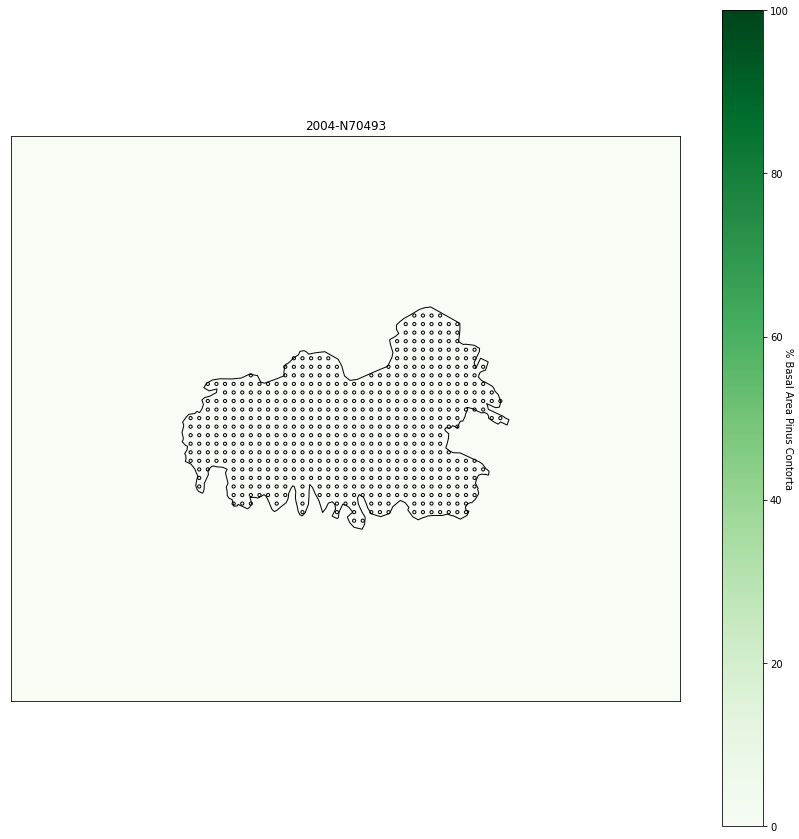

    Pinus_Contorta median  ...                                           geometry
0               55.156666  ...  POLYGON Z ((-1847707.875367416 1839358.5681704...
1                3.330000  ...  POLYGON Z ((-1840831.16513708 1833883.26429208...
2                0.000000  ...  POLYGON Z ((-1923691.782544946 1757165.1283484...
3                0.000000  ...  POLYGON Z ((-1955201.392325317 1790387.3561371...
4                0.000000  ...  POLYGON Z ((-1951428.278481783 1877815.2345960...
5                0.000000  ...  POLYGON Z ((-1946470.818380296 1734122.8832369...
6                0.000000  ...  POLYGON Z ((-1961241.948413799 1859500.9570208...
7               14.669999  ...  POLYGON Z ((-1523645.674311292 1684214.2937085...
8                3.900000  ...  POLYGON Z ((-1494882.122318848 1696045.5449102...
9               34.489998  ...  POLYGON Z ((-1836979.149665477 1909064.2160223...
10               6.503334  ...  POLYGON Z ((-1803281.02575714 1879735.98750379...
11              

In [59]:
pinus_contorta_df = get_species_for_fire('Pinus_Contorta')
#Send the output dataframe to a text file store in google drive 
pinus_contorta_df.to_csv('pinus_contorta_in_cnfdb_fires.txt',sep=',')